In [14]:
import polars as pl
import missingno as msno
import plotly.express as px
import matplotlib.pyplot as plt


In [15]:
# Load data from ../data/Kaffee_Tee_Mate_und_Gewuerze_2021-2025.csv
df_raw = pl.read_csv("../data/Kaffee_Tee_Mate_und_Gewuerze_2021-2025.csv", separator=";")

# Rename to English
df = df_raw.rename(
    {
        "Zeit": "period",
        "Einfuhr Menge in kg": "import_qty_kg",
        "Ausfuhr Menge in kg": "export_qty_kg",
        "Ausfuhr Wert in Euro": "export_value_eur",
        "Einfuhr Wert in Euro": "import_value_eur",
    }
)

# Convert German month strings like "Jan.21", "Mai.21" into an actual date (YYYY-MM-01)
month_map = {
    "Jan": "01",
    "Feb": "02",
    "Mar": "03",
    "Apr": "04",
    "Mai": "05",
    "Jun": "06",
    "Jul": "07",
    "Aug": "08",
    "Sep": "09",
    "Okt": "10",
    "Nov": "11",
    "Dez": "12",
}

period_clean = pl.col("period").str.strip_chars().str.replace(".", "", literal=True)
month_num = period_clean.str.slice(0, 3).str.replace_many(month_map)
year_2 = period_clean.str.slice(3, 2)

df = df.with_columns(
    pl.format("20{}-{}-01", year_2, month_num)
    .str.to_date("%Y-%m-%d")
    .alias("date")
).drop("period")

df

import_qty_kg,export_qty_kg,export_value_eur,import_value_eur,date
i64,i64,i64,i64,date
5935052,1845453,13273803,32853089,2021-01-01
6102042,1947588,13892659,37899788,2021-02-01
7025383,2268933,16612258,39440957,2021-03-01
7886879,1795644,12670661,44392204,2021-04-01
6532708,1890993,13158053,37773444,2021-05-01
…,…,…,…,…
6709337,1897283,20478482,60794016,2025-05-01
7237690,1868009,19961474,66174649,2025-06-01
6930871,2154189,22865544,65539634,2025-07-01


In [16]:
# Plot helper
def plot_timeseries(df: pl.DataFrame, value_cols: list[str], title: str):
    df_plot = df.sort("date").select(["date", *value_cols])
    df_long = df_plot.unpivot(
        index="date",
        on=value_cols,
        variable_name="series",
        value_name="value",
    )
    fig = px.line(
        df_long.to_pandas(),
        x="date",
        y="value",
        color="series",
        title=title,
    )
    fig.show()
    return fig

Inflation correction with data from wko. 
https://www.wko.at/statistik/prognose/inflation.pdf

- 2025: 3.5%
- 2024: 2.9%
- 2023: 7.8%
- 2022: 8.6%
- 2021: 2.8%

In [17]:
# Inflation-adjust the EUR value columns (convert to real 2025 EUR) and plot
import polars as pl

inflation = {
    2021: 0.028,
    2022: 0.086,
    2023: 0.078,
    2024: 0.029,
    2025: 0.035,
}

# Build a simple CPI index with 2020 = 1.0 (so 2021 includes 2021 inflation, etc.)
cpi = {}
cpi_prev = 1.0
for year in sorted(inflation):
    cpi_prev *= 1 + inflation[year]
    cpi[year] = cpi_prev

cpi_2025 = cpi[2025]
cpi_df = pl.DataFrame({"year": list(cpi.keys()), "cpi": list(cpi.values())})

df = (
    df.with_columns(pl.col("date").dt.year().alias("year"))
    .join(cpi_df, on="year", how="left")
    .with_columns(
        (pl.col("export_value_eur") * (cpi_2025 / pl.col("cpi"))).alias(
            "export_value_eur_real_2025"
        ),
        (pl.col("import_value_eur") * (cpi_2025 / pl.col("cpi"))).alias(
            "import_value_eur_real_2025"
        ),
    )
    .drop(["year", "cpi"])
)

# 1) Your original four-series view, but with inflation-adjusted EUR values
value_cols_real = [
    "import_qty_kg",
    "export_qty_kg",
    "export_value_eur_real_2025",
    "import_value_eur_real_2025",
]
fig_real = plot_timeseries(
    df,
    value_cols=value_cols_real,
    title="Import/Export: quantities + inflation-adjusted values (real 2025 EUR)",
)

# 2) Comparison: nominal EUR vs real (inflation-adjusted) EUR
value_cols_compare = [
    "export_value_eur",
    "export_value_eur_real_2025",
    "import_value_eur",
    "import_value_eur_real_2025",
]
fig_compare = plot_timeseries(
    df,
    value_cols=value_cols_compare,
    title="Nominal vs real values: EUR vs real 2025 EUR (inflation-adjusted)",
)

df

import_qty_kg,export_qty_kg,export_value_eur,import_value_eur,date,export_value_eur_real_2025,import_value_eur_real_2025
i64,i64,i64,i64,date,f64,f64
5935052,1845453,13273803,32853089,2021-01-01,1.6550e7,4.0962e7
6102042,1947588,13892659,37899788,2021-02-01,1.7322e7,4.7254e7
7025383,2268933,16612258,39440957,2021-03-01,2.0713e7,4.9176e7
7886879,1795644,12670661,44392204,2021-04-01,1.5798e7,5.5349e7
6532708,1890993,13158053,37773444,2021-05-01,1.6406e7,4.7097e7
…,…,…,…,…,…,…
6709337,1897283,20478482,60794016,2025-05-01,2.0478482e7,6.0794016e7
7237690,1868009,19961474,66174649,2025-06-01,1.9961474e7,6.6174649e7
6930871,2154189,22865544,65539634,2025-07-01,2.2865544e7,6.5539634e7


Real 2025 EUR” is just the price level you’re expressing everything in (the base year), not the range of years used to compute inflation


build a CPI-like index by compounding the given annual inflation rates for 2021–2025,
then rescale each nominal value by 
CPI
2025
/
CPI
year
CPI 
2025
​
 /CPI 
year
​
 .
So a value from 2021 is “inflation-adjusted from 2021 → 2025” and is therefore expressed in 2025 euros (same purchasing power as 2025). That’s why the column name ends with _real_2025.

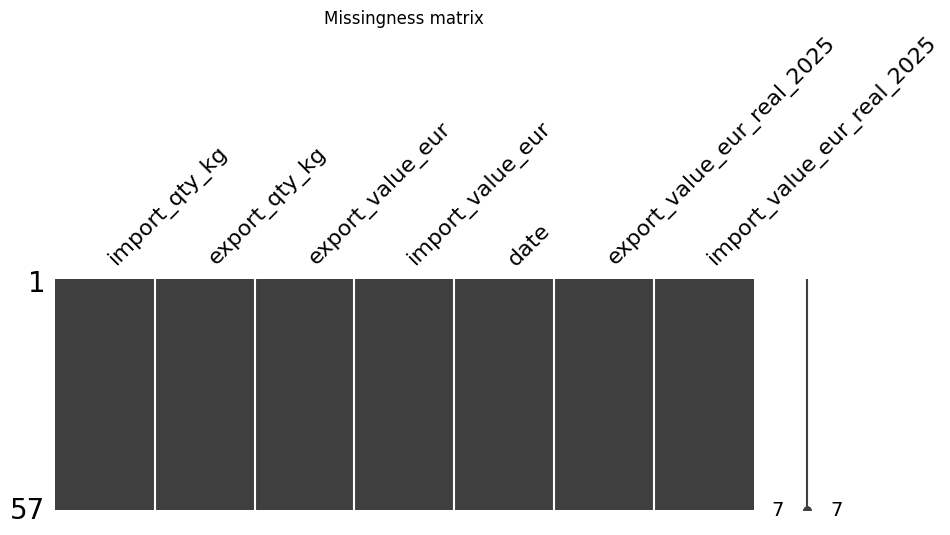

In [18]:
pdf = df.to_pandas()

# Visual missingness matrix (rows = observations, cols = variables)
msno.matrix(pdf, figsize=(10, 3))
plt.title("Missingness matrix")
plt.show()

## Time series diagnostics (ADF, KPSS, STL)

This section adds a small “diagnostic stack” to quickly check stationarity and visualize trend/seasonality via STL decomposition.

- **ADF** (Augmented Dickey–Fuller): $H_0$ = unit root (non-stationary)
- **KPSS**: $H_0$ = stationary (level-stationary by default)

A common outcome is:
- ADF **fails** to reject + KPSS **rejects** → likely non-stationary
- ADF **rejects** + KPSS **fails** to reject → likely stationary
- Both reject → may be trend-stationary / structural breaks / other issues
- Both fail → test power is low (short series, noisy series)

,import_qty_kg
date,
2021-01-01,5935052.0
2021-02-01,6102042.0
2021-03-01,7025383.0
2021-04-01,7886879.0
2021-05-01,6532708.0


,series,test,H0,stat,p_value,lags,nobs,crit_1%,crit_5%,crit_10%
0,import_qty_kg,ADF,unit root (non-stationary),-1.692111,0.435181,10,46,-3.581258,-2.926785,-2.601541
1,import_qty_kg,KPSS,stationary (level),0.079120,0.100000,3,57,0.739000,0.463000,0.347000


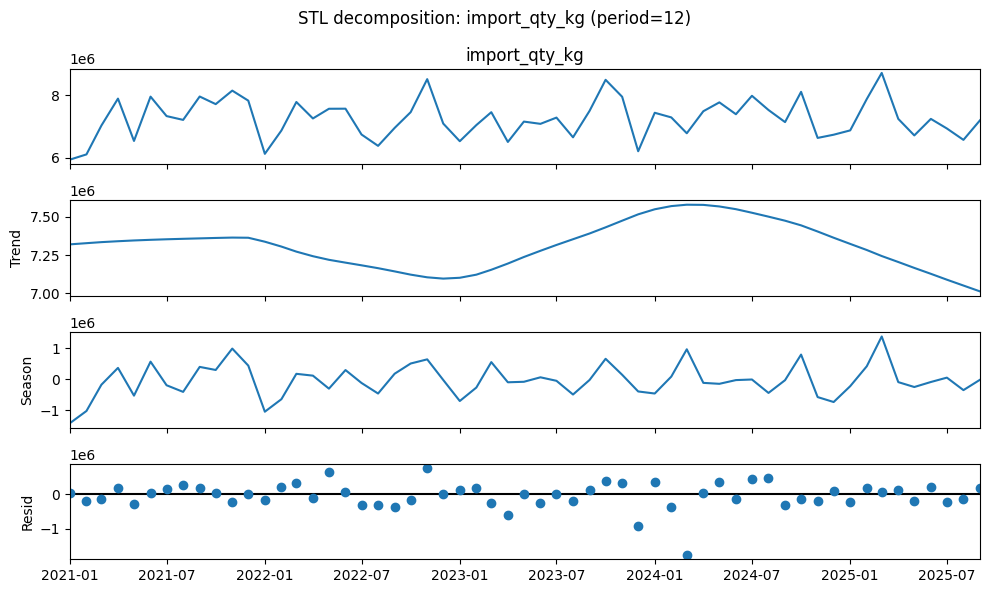

Using series: import_qty_kg


In [19]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import STL
from statsmodels.tools.sm_exceptions import InterpolationWarning


def _as_time_series(
    pdf: pd.DataFrame,
    value_col: str,
    date_col: str = "date",
) -> pd.Series:
    if date_col not in pdf.columns:
        raise KeyError(f"date_col '{date_col}' not found in pdf.columns")
    if value_col not in pdf.columns:
        raise KeyError(f"value_col '{value_col}' not found in pdf.columns")

    ts = (
        pdf[[date_col, value_col]]
        .dropna()
        .assign(**{date_col: pd.to_datetime(pdf[date_col])})
        .sort_values(date_col)
        .set_index(date_col)[value_col]
        .astype(float)
    )
    ts.name = value_col
    return ts


def stationarity_report(ts: pd.Series) -> pd.DataFrame:
    ts = ts.dropna()

    adf_stat, adf_p, adf_lags, adf_nobs, adf_crit, _ = adfuller(ts, autolag="AIC")

    # KPSS commonly emits InterpolationWarning when p-value is outside lookup table.
    # That's not fatal; we suppress it to keep notebook output clean.
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", InterpolationWarning)
        kpss_stat, kpss_p, kpss_lags, kpss_crit = kpss(
            ts, regression="c", nlags="auto"
        )

    rows = [
        {
            "test": "ADF",
            "H0": "unit root (non-stationary)",
            "stat": adf_stat,
            "p_value": adf_p,
            "lags": adf_lags,
            "nobs": adf_nobs,
            "crit_1%": adf_crit.get("1%"),
            "crit_5%": adf_crit.get("5%"),
            "crit_10%": adf_crit.get("10%"),
        },
        {
            "test": "KPSS",
            "H0": "stationary (level)",
            "stat": kpss_stat,
            "p_value": kpss_p,
            "lags": kpss_lags,
            "nobs": len(ts),
            "crit_1%": kpss_crit.get("1%"),
            "crit_5%": kpss_crit.get("5%"),
            "crit_10%": kpss_crit.get("10%"),
        },
    ]

    out = pd.DataFrame(rows)
    out.insert(0, "series", ts.name)
    return out


def stl_decomposition(ts: pd.Series, period: int = 12, robust: bool = True):
    ts = ts.dropna()
    fit = STL(ts, period=period, robust=robust).fit()
    fig = fit.plot()
    fig.set_size_inches(10, 6)
    fig.suptitle(f"STL decomposition: {ts.name} (period={period})")
    plt.tight_layout()
    plt.show()
    return fit


def diagnostic_stack(
    pdf: pd.DataFrame,
    value_col: str,
    date_col: str = "date",
    stl_period: int = 12,
):
    ts = _as_time_series(pdf, value_col=value_col, date_col=date_col)

    display(ts.to_frame().head())
    display(stationarity_report(ts))
    stl_fit = stl_decomposition(ts, period=stl_period, robust=True)

    return ts, stl_fit


# Pick a sensible default series
_numeric_cols = [
    c for c in pdf.columns if c != "date" and pd.api.types.is_numeric_dtype(pdf[c])
]
DEFAULT_SERIES = (
    "import_qty_kg"
    if "import_qty_kg" in pdf.columns
    else (_numeric_cols[0] if _numeric_cols else None)
)

if DEFAULT_SERIES is None:
    raise ValueError("No numeric columns found in pdf for stationarity diagnostics")

ts, stl_fit = diagnostic_stack(
    pdf, value_col=DEFAULT_SERIES, date_col="date", stl_period=12
)
print("Using series:", DEFAULT_SERIES)

,seasonal_mean,seasonal_mean_abs,seasonal_peak_to_peak
date,,,
2021,-59528.880640,569287.629499,2.414867e+06
2022,-59258.819015,377331.151543,1.694451e+06
2023,-59895.811580,295787.397694,1.366389e+06
2024,-60215.463893,368126.583895,1.707054e+06
2025,90092.736831,321111.036618,1.736647e+06


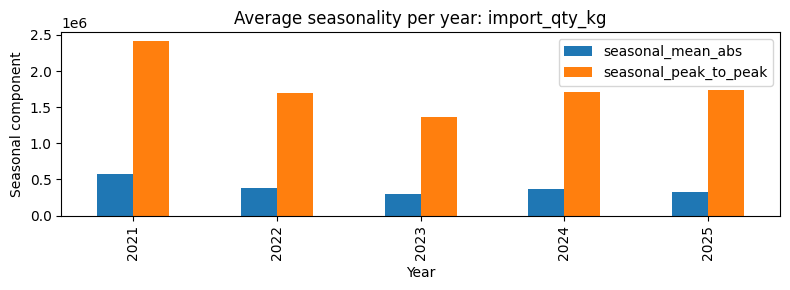

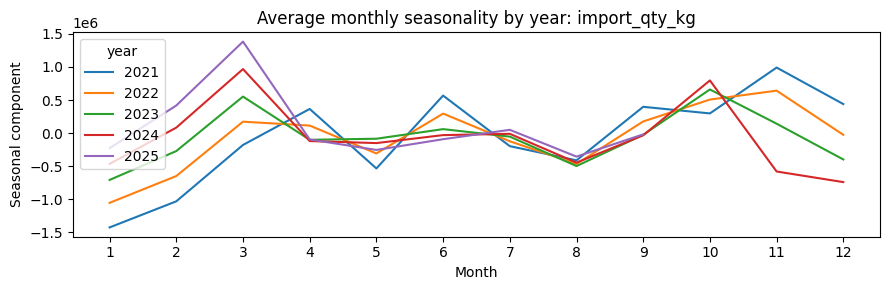

In [20]:
# Avg seasonality per year (from STL seasonal component)
seasonal = stl_fit.seasonal.dropna()

seasonal_by_year = pd.DataFrame(
    {
        "seasonal_mean": seasonal.groupby(seasonal.index.year).mean(),
        "seasonal_mean_abs": seasonal.groupby(seasonal.index.year).apply(lambda s: s.abs().mean()),
        "seasonal_peak_to_peak": seasonal.groupby(seasonal.index.year).apply(lambda s: s.max() - s.min()),
    }
)

display(seasonal_by_year)

ax = seasonal_by_year[["seasonal_mean_abs", "seasonal_peak_to_peak"]].plot(kind="bar", figsize=(8, 3))
ax.set_title(f"Average seasonality per year: {DEFAULT_SERIES}")
ax.set_xlabel("Year")
ax.set_ylabel("Seasonal component")
plt.tight_layout()
plt.show()

# Optional: average seasonal pattern per month (separate line per year)
seasonal_monthly = (
    seasonal.to_frame("seasonal")
    .assign(year=seasonal.index.year, month=seasonal.index.month)
    .groupby(["year", "month"], as_index=False)["seasonal"].mean()
    .pivot(index="month", columns="year", values="seasonal")
)

ax = seasonal_monthly.plot(figsize=(9, 3))
ax.set_title(f"Average monthly seasonality by year: {DEFAULT_SERIES}")
ax.set_xlabel("Month")
ax.set_ylabel("Seasonal component")
ax.set_xticks(range(1, 13))
plt.tight_layout()
plt.show()